## Library Imports

In [1]:
import os
import warnings
import pickle
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import SubsetRandomSampler

import numpy as np
%matplotlib inline

import bts.dataset as dataset
import bts.model as model
import bts.classifier as classifier
import bts.plot as plot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

# To Start TensorBoard
# tensorboard --logdir logs --samples_per_plugin images=200

Computation Details
	Device Used: (cuda)  GeForce RTX 2080 Super

Packages Used Versions:-
	Pytorch Version: 1.6.0


## Hyperparameters Tuning 

In [2]:
# Dataset part used for testing
TEST_SPLIT = 0.2
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Dataset folder used
DATASET_USED = 'png_dataset'
# Full Dataset path
DATASET_PATH = os.path.join('dataset',DATASET_USED)
# Training Epochs
EPOCHS = 120
# Filters used in UNet Model
FILTER_LIST = [16,32,64,128,256]
# Flag to train the model
TRAIN = True
# Flag to load saved model
LOAD_MODEL = False
# Flag to save model trained
SAVE_MODEL = True
# Model name to save or load.
MODEL_NAME = f"UNet-{FILTER_LIST}.pt"

print(f"Model Name :   {MODEL_NAME}")

Model Name :   UNet-[16, 32, 64, 128, 256].pt


## Dataset Loading

In [3]:
def get_indices(length, new=False):
    """ Gets the Training & Testing data indices for a
    paticular "DATASET_USED".Stores the indices and returns
    them back when the same dataset is used.
    Parameters:
        length(int): Length of the dataset used.
        new(bool): Discard the saved indices and get new ones.
    Return:
        train_indices(list): Array of indices used for training purpose.
        test_indices(list): Array of indices used for testing purpose.
    """
    # Pickle file location of the indices.
    file_path = os.path.join('dataset',f'split_indices_{DATASET_USED}.p')
    data = dict()
    if os.path.isfile(file_path) and not new:
        # File found.
        with open(file_path,'rb') as file :
            data = pickle.load(file)
            return data['train_indices'], data['test_indices']
    else:
        # File not found or fresh copy is required.
        indices = list(range(length))
        np.random.shuffle(indices)
        split = int(np.floor(TEST_SPLIT * len(tumor_dataset)))
        train_indices , test_indices = indices[split:], indices[:split]
        # Indices are saved with pickle.
        data['train_indices'] = train_indices
        data['test_indices'] = test_indices
        with open(file_path,'wb') as file:
            pickle.dump(data,file)
    return train_indices, test_indices

In [4]:
tumor_dataset = dataset.TumorDataset(DATASET_PATH)

train_indices, test_indices = get_indices(len(tumor_dataset))
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler=test_sampler)

## Model Declaration

In [11]:
unet_model = None
unet_classifier = None
if not LOAD_MODEL:
    # New model is created.
    unet_model = model.DynamicUNet(FILTER_LIST).to(device)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
else:
    # Saved model is loaded on memory.
    unet_model = model.DynamicUNet(FILTER_LIST)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
    unet_classifier.restore_model(os.path.join('saved_models',MODEL_NAME))
    print('Saved model loaded')

#### Uncomment this section if visualization of training progress is required on Tensorboard

In [6]:
"""
till = 8
choice = test_indices[:till]
sample = list()
for _ in range(till):
    sample.append(dataset[choice[_]])
"""

'\ntill = 8\nchoice = test_indices[:till]\nsample = list()\nfor _ in range(till):\n    sample.append(dataset[choice[_]])\n'

## Model Training

In [7]:
# Training process

unet_model.train()
path = os.path.join('saved_models',MODEL_NAME) if SAVE_MODEL else None
unet_train_history = unet_classifier.train(EPOCHS,trainloader,mini_batch=100,save_best=path)
print(f'Training Finished after {EPOCHS} epoches')

# Testing process on test data.
unet_model.eval()
unet_score = unet_classifier.test(testloader)
print(f'\n\nDice Score {unet_score}')
# Dice Score 0.7446110107881675

Starting Training Process
    Batch: 100,	Batch Loss: 0.1887976
    Batch: 200,	Batch Loss: 0.1683904
    Batch: 300,	Batch Loss: 0.1612642
    Batch: 400,	Batch Loss: 0.1565956
Epoch: 001,  Loss:0.1683686,  Time:94.94secs	Saved at loss: 0.1683686409
    Batch: 100,	Batch Loss: 0.1582329
    Batch: 200,	Batch Loss: 0.1506131
    Batch: 300,	Batch Loss: 0.1484701
    Batch: 400,	Batch Loss: 0.1487243
Epoch: 002,  Loss:0.1513374,  Time:78.19secs	Saved at loss: 0.1513374425
    Batch: 100,	Batch Loss: 0.1420628
    Batch: 200,	Batch Loss: 0.1477410
    Batch: 300,	Batch Loss: 0.1415804
    Batch: 400,	Batch Loss: 0.1455552
Epoch: 003,  Loss:0.1440012,  Time:80.18secs	Saved at loss: 0.1440012331
    Batch: 100,	Batch Loss: 0.1315656
    Batch: 200,	Batch Loss: 0.1292209
    Batch: 300,	Batch Loss: 0.1325917
    Batch: 400,	Batch Loss: 0.1315023
Epoch: 004,  Loss:0.1312908,  Time:78.39secs	Saved at loss: 0.1312907806
    Batch: 100,	Batch Loss: 0.1275869
    Batch: 200,	Batch Loss: 0.120637

    Batch: 100,	Batch Loss: 0.0645530
    Batch: 200,	Batch Loss: 0.0673236
    Batch: 300,	Batch Loss: 0.0636320
    Batch: 400,	Batch Loss: 0.0655793
Epoch: 038,  Loss:0.0650091,  Time:78.66secs
    Batch: 100,	Batch Loss: 0.0616696
    Batch: 200,	Batch Loss: 0.0645785
    Batch: 300,	Batch Loss: 0.0618043
    Batch: 400,	Batch Loss: 0.0615202
Epoch: 039,  Loss:0.0623462,  Time:78.44secs	Saved at loss: 0.0623462298
    Batch: 100,	Batch Loss: 0.0625651
    Batch: 200,	Batch Loss: 0.0632604
    Batch: 300,	Batch Loss: 0.0646288
    Batch: 400,	Batch Loss: 0.0658176
Epoch: 040,  Loss:0.0639730,  Time:78.34secs
    Batch: 100,	Batch Loss: 0.0663400
    Batch: 200,	Batch Loss: 0.0620948
    Batch: 300,	Batch Loss: 0.0638317
    Batch: 400,	Batch Loss: 0.0584022
Epoch: 041,  Loss:0.0625463,  Time:78.58secs
    Batch: 100,	Batch Loss: 0.0600857
    Batch: 200,	Batch Loss: 0.0628338
    Batch: 300,	Batch Loss: 0.0631389
    Batch: 400,	Batch Loss: 0.0601786
Epoch: 042,  Loss:0.0614373,  Ti

    Batch: 300,	Batch Loss: 0.0466961
    Batch: 400,	Batch Loss: 0.0468088
Epoch: 076,  Loss:0.0475211,  Time:78.58secs
    Batch: 100,	Batch Loss: 0.0422917
    Batch: 200,	Batch Loss: 0.0476488
    Batch: 300,	Batch Loss: 0.0469788
    Batch: 400,	Batch Loss: 0.0476264
Epoch: 077,  Loss:0.0461076,  Time:78.38secs	Saved at loss: 0.0461075802
    Batch: 100,	Batch Loss: 0.0483369
    Batch: 200,	Batch Loss: 0.0471620
    Batch: 300,	Batch Loss: 0.0476453
    Batch: 400,	Batch Loss: 0.0495691
Epoch: 078,  Loss:0.0484588,  Time:78.17secs
    Batch: 100,	Batch Loss: 0.0487268
    Batch: 200,	Batch Loss: 0.0442630
    Batch: 300,	Batch Loss: 0.0468353
    Batch: 400,	Batch Loss: 0.0464948
Epoch: 079,  Loss:0.0466286,  Time:78.09secs
    Batch: 100,	Batch Loss: 0.0456903
    Batch: 200,	Batch Loss: 0.0468426
    Batch: 300,	Batch Loss: 0.0480119
    Batch: 400,	Batch Loss: 0.0467167
Epoch    80: reducing learning rate of group 0 to 5.2201e-04.
Epoch: 080,  Loss:0.0469603,  Time:78.25secs
 

    Batch: 200,	Batch Loss: 0.0366465
    Batch: 300,	Batch Loss: 0.0377455
    Batch: 400,	Batch Loss: 0.0343015
Epoch   114: reducing learning rate of group 0 to 2.3162e-04.
Epoch: 114,  Loss:0.0375335,  Time:78.25secs
    Batch: 100,	Batch Loss: 0.0392798
    Batch: 200,	Batch Loss: 0.0364699
    Batch: 300,	Batch Loss: 0.0367459
    Batch: 400,	Batch Loss: 0.0392083
Epoch: 115,  Loss:0.0378048,  Time:78.19secs
    Batch: 100,	Batch Loss: 0.0360080
    Batch: 200,	Batch Loss: 0.0348410
    Batch: 300,	Batch Loss: 0.0370249
    Batch: 400,	Batch Loss: 0.0380664
Epoch: 116,  Loss:0.0365613,  Time:78.29secs	Saved at loss: 0.0365612870
    Batch: 100,	Batch Loss: 0.0347947
    Batch: 200,	Batch Loss: 0.0374759
    Batch: 300,	Batch Loss: 0.0367522
    Batch: 400,	Batch Loss: 0.0356975
Epoch: 117,  Loss:0.0362005,  Time:78.02secs	Saved at loss: 0.0362005263
    Batch: 100,	Batch Loss: 0.0356759
    Batch: 200,	Batch Loss: 0.0399434
    Batch: 300,	Batch Loss: 0.0406123
    Batch: 400,	Ba

## Training Results

### Training Loss Graph

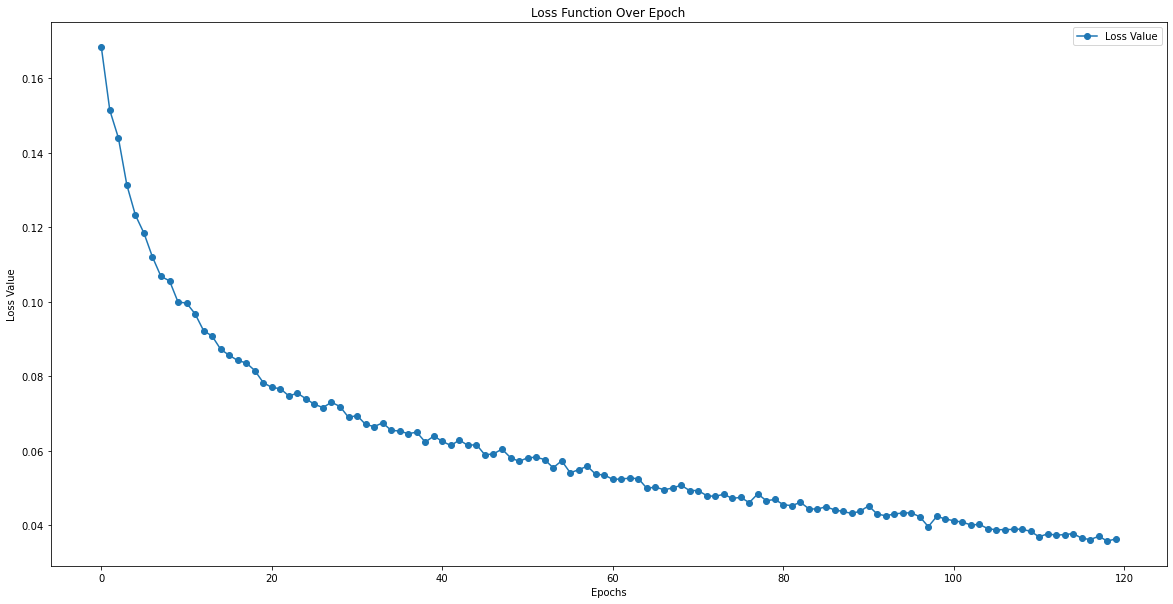

In [8]:
save_plot = os.path.join('images',f'{MODEL_NAME}-loss_graph.png')
plot.loss_graph(unet_train_history['train_loss'],save_plot)

### Visualize Test Dataset Predictions
Run the 2nd cell to get new predictions of different data

In [18]:
i=1

In [19]:
unet_model = model.DynamicUNet(FILTER_LIST)
unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
unet_classifier.restore_model(os.path.join('saved_models',MODEL_NAME))

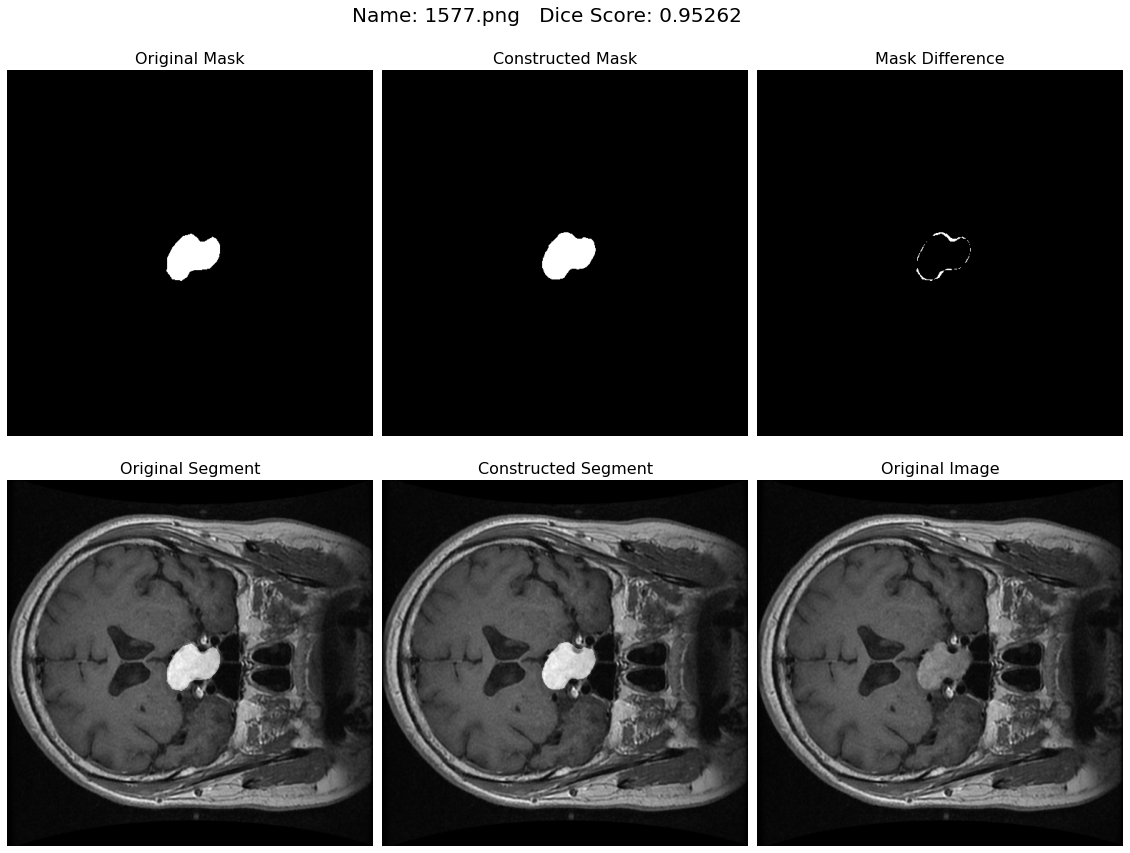

In [20]:
# Run this cell repeatedly to see some results.
image_index = test_indices[i]
sample = tumor_dataset[image_index]
image, mask, output, d_score = unet_classifier.predict(sample,0.65)
title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}'
# save_path = os.path.join('images',f'{d_score:.5f}_{image_index}.png')
plot.result(image,mask,output,title,save_path=None)
i += 1
if i >= len(test_indices):
    i = 0 